# Large Data Limits & Rescaled t-SNE

### Setup

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from openTSNE import TSNE

In [22]:
# for local imports  
from pathlib import Path
import sys
import os 

script_dir = Path.cwd().parent / "scripts"
sys.path.append(str(script_dir))

figures_dir = Path.cwd().parent / "figures"
sys.path.append(str(figures_dir))

results_dir = Path.cwd().parent / "results"
sys.path.append(str(results_dir))

import datasets

## Helper Functions

### running standard and rescaled t-SNE

In [23]:
def run_rescaled_tsne(data, seed, kappa=30, alpha=0.1, b=0.15):
    """
    Run t-SNE with a rescaled perplexity and exaggeration factor.

    Parameters:
      - data: ndarray of shape (n_samples, n_features)
      - kappa: base constant (effective number of neighbors)
      - alpha: exponent to allow perplexity to grow as n^alpha
      
    Returns:
      - embedding: 2D embedding from t-SNE.
    """
    n, d = data.shape
    # Note: b needs to be larger than 1/d and smaller than 1 
    h_n = n ** (-b)
    # Perplexity should be chosen to scale slowly with n.
    scaled_perplexity = kappa * (n ** alpha)
    # Early exaggeration factor: rescale the attractive term by 1/h_n^2.
    exaggeration = 1 / (h_n ** 2)
    
    print(f"n = {n}, d = {d}, b={b}")
    print(f"Computed h_n = {h_n:.4f}")
    print(f"Using perplexity = {scaled_perplexity:.2f} (base κ = {kappa}, exponent α = {alpha})")
    print(f"Using early exaggeration = {exaggeration:.2f}")

    # keep on EE for the entirety of the optimization  
    tsne = TSNE(
        perplexity=scaled_perplexity,
        early_exaggeration=exaggeration,
        exaggeration=exaggeration, 
        n_jobs=-1,
        random_state=seed,
        verbose=True
    )
    embedding = tsne.fit(data)
    return embedding

In [24]:
def run_standard_tsne(data, seed):
    """
    Run standard t-SNE with fixed perplexity and exaggeration.
    """
    tsne = TSNE(n_jobs=-1, random_state=seed, verbose=False)
    return tsne.fit(data)

### sampling points from mixture of Gaussians

In [25]:
def sample_gaussian_mixture(n_samples: int, dim: int, n_components: int = 5, spread: float = 5.0):
    """
    Generates samples from a Gaussian Mixture Model with equidistant Gaussian components in high dimensions.

    Parameters:
    - n_samples (int): Total number of samples to generate.
    - dim (int): Dimensionality of the data.
    - n_components (int): Number of Gaussian components (default: 5).
    - spread (float): Controls how far apart the Gaussian centers are (default: 5.0).

    Returns:
    - X (numpy.ndarray): Sampled data of shape (n_samples, dim).
    - labels (numpy.ndarray): Cluster labels for each sample.
    """
    np.random.seed(42)

    # Generate random Gaussian centers in high-dimensional space
    means = np.random.randn(n_components, dim) * spread  # Spread them apart

    # Covariance matrices (identity matrices for simplicity)
    covariances = [np.eye(dim) for _ in range(n_components)]

    # Equal mixing probabilities (each Gaussian has 1/n_components probability)
    component_choices = np.random.choice(n_components, size=n_samples, p=np.ones(n_components) / n_components)

    # Sample from the selected Gaussians
    X = np.array([np.random.multivariate_normal(means[comp], covariances[comp]) for comp in component_choices])

    return X, component_choices  # Return data and the labels indicating which Gaussian each point came from


### Embedding Dict (running both standard and rescaled tSNE on different sample sizes and seeds)

In [26]:
def generate_embedding_dict_gaussian(gaussian_data, sample_sizes, seeds, b=0.15, kappa=30):

    embeddings = {}
    for i, n in enumerate(sample_sizes):
        X, y = gaussian_data[i]
        # Generate synthetic data
        for seed in seeds: 
            # Compute embeddings
            emb_standard = run_standard_tsne(X, seed)
            emb_rescaled = run_rescaled_tsne(X, seed, kappa=kappa, alpha=0.05, b=b)
            
            embeddings[(n, (seed, "standard"))] = (emb_standard, y)
            embeddings[(n, (seed, "rescaled"))] = (emb_rescaled, y)
    
    return embeddings

In [27]:
def generate_embedding_dict_mnist(n_samples, seeds, b=0.15, kappa=30):
    X, y = datasets.load_mnist()
    embeddings = {}
    for n in n_samples:
        # Generate synthetic data
        data_sample, labels = datasets.load_n_samples(n, X, y)

        for seed in seeds: 
            # Compute embeddings
            emb_standard = run_standard_tsne(data_sample.to_numpy(), seed)
            emb_rescaled = run_rescaled_tsne(data_sample.to_numpy(), seed, kappa=kappa, alpha=0.05, b=b)
            
            embeddings[(n, (seed, "standard"))] = (emb_standard, labels)
            embeddings[(n, (seed, "rescaled"))] = (emb_rescaled, labels)
    
    return embeddings

### plotting grids

In [49]:
def plot_embedding_grid(embeddings, seeds, sample_sizes, dataset_name, embedding_type='standard', cmap="tab20b", pointsize=5):
    """
    Plots a grid of t-SNE embeddings for the given embedding type (either 'standard' or 'rescaled').
    Each grid has one column per sample size and one row per seed.
    
    Parameters:
      embeddings (dict): Dictionary with keys of the form (sample_size, (seed, embedding_type))
                         where embedding_type is either "standard" or "rescaled".
                         Each value is a tuple (embedding, labels).
      seeds (list): List of seeds used.
      sample_sizes (list): List of sample sizes.
      dataset_name (str): Prefix for the saved filename.
      embedding_type (str): Which embedding type to plot. Must be either "standard" or "rescaled".
      cmap (str): Colormap to use.
    """
    n_rows = len(seeds)
    n_cols = len(sample_sizes)
    subplot_size = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, subplot_size * n_rows), squeeze=False)
    
    for row_idx, seed in enumerate(seeds):
        for col_idx, sample in enumerate(sample_sizes):
            ax = axes[row_idx, col_idx]
            key = (sample, (seed, embedding_type))
            if key not in embeddings:
                ax.axis("off")
                continue
            embedding, labels = embeddings[key]
            ax.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap=cmap, s=pointsize, alpha=0.8)
            
            # Configure tick parameters: smaller tick lengths/widths with font size 12.
            ax.tick_params(axis='both', which='major', width=0.8, length=4)
            ax.tick_params(axis='both', which='minor', width=0.5, length=2)
            
            # Ensure that the spines (the outline) are visible with a reduced linewidth.
            for spine in ax.spines.values():
                spine.set_linewidth(0.8)
            
            # For the top row, add a title displaying the sample size.
            if row_idx == 0:
                ax.set_title(f"n = {sample}", fontsize=12, pad=10)
            # For the leftmost column, add a label displaying the seed.
            #if col_idx == 0:
            #    ax.set_ylabel(f"Seed: {seed}", fontsize=12, labelpad=10)
    
    plt.tight_layout()
    save_path = os.path.join(figures_dir, f"{dataset_name}_{embedding_type}_embedding_grid.png")
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()


### histograms for density

This function is not up to date yet. 

In [9]:
def plot_density_histograms(data_sizes, embeddings, bins=100):
    """
    Plots 2D density histograms (heatmaps) for standard and rescaled t-SNE embeddings.
    
    Parameters:
    - data_sizes (list): List of sample sizes used.
    - embeddings (list of tuples): Contains (standard_tsne, rescaled_tsne, labels).
    - bins (int): Number of bins for 2D histogram (default: 100).
    """
    num_rows = len(data_sizes)
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 5 * num_rows))
    fig.suptitle("Density Histograms Comparison", fontsize=14, y=1.02)

    for i, (emb_standard, emb_rescaled, _) in enumerate(embeddings):
        # Density histogram for standard t-SNE
        ax1 = axes[i, 0]
        ax1.hist2d(emb_standard[:, 0], emb_standard[:, 1], bins=bins, cmap="magma")
        ax1.set_title(f"Standard t-SNE ({data_sizes[i]} points)")

        # Density histogram for rescaled t-SNE
        ax2 = axes[i, 1]
        ax2.hist2d(emb_rescaled[:, 0], emb_rescaled[:, 1], bins=bins, cmap="magma")
        ax2.set_title(f"Rescaled t-SNE ({data_sizes[i]} points)")

    plt.tight_layout()
    plt.show()

## Experiments

### new experiments

In [16]:
seeds = [1, 12, 42]

In [ ]:
data_sizes = [100, 1000, 10000, 100000]

gaussian_data = [sample_gaussian_mixture(n, dim=50) for n in data_sizes]

In [19]:
embedding_dict = generate_embedding_dict_gaussian(gaussian_data, data_sizes, seeds, b=0.15)

Perplexity value 30 is too high. Using perplexity 3.00 instead


Perplexity value 33 is too high. Using perplexity 3.00 instead


n = 10, d = 50, b=0.15
Computed h_n = 0.7079
Using perplexity = 33.66 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 2.00
--------------------------------------------------------------------------------
TSNE(early_exaggeration=1.9952623149688797, exaggeration=1.9952623149688797,
     n_jobs=-1, perplexity=33.6605536290589, random_state=1, verbose=True)
--------------------------------------------------------------------------------
===> Finding 9 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=2.00, lr=5.01 for 250 iterations...
Iteration   50, KL divergence 0.1151, 50 iterations in 0.1466 sec
Iteration  100, KL divergence 0.1417, 50 iterations in 0.0883 sec
Iteration  150, KL divergence 0.1417, 50 iterations in 0.0897 sec
Iteration 

Perplexity value 30 is too high. Using perplexity 3.00 instead


Iteration  300, KL divergence 0.1412, 50 iterations in 0.0738 sec
Iteration  350, KL divergence 0.1412, 50 iterations in 0.0585 sec
Iteration  400, KL divergence 0.1411, 50 iterations in 0.0232 sec
Iteration  450, KL divergence 0.1412, 50 iterations in 0.0289 sec
Iteration  500, KL divergence 0.1412, 50 iterations in 0.0456 sec
   --> Time elapsed: 0.61 seconds


Perplexity value 33 is too high. Using perplexity 3.00 instead


n = 10, d = 50, b=0.15
Computed h_n = 0.7079
Using perplexity = 33.66 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 2.00
--------------------------------------------------------------------------------
TSNE(early_exaggeration=1.9952623149688797, exaggeration=1.9952623149688797,
     n_jobs=-1, perplexity=33.6605536290589, random_state=12, verbose=True)
--------------------------------------------------------------------------------
===> Finding 9 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.09 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=2.00, lr=5.01 for 250 iterations...
Iteration   50, KL divergence 0.1151, 50 iterations in 0.0334 sec
Iteration  100, KL divergence 0.1417, 50 iterations in 0.0672 sec
Iteration  150, KL divergence 0.1417, 50 iterations in 0.1914 sec
Iteration

Perplexity value 30 is too high. Using perplexity 3.00 instead


Iteration  300, KL divergence 0.1410, 50 iterations in 0.0321 sec
Iteration  350, KL divergence 0.1412, 50 iterations in 0.0360 sec
Iteration  400, KL divergence 0.1412, 50 iterations in 0.0668 sec
Iteration  450, KL divergence 0.1411, 50 iterations in 0.0199 sec
Iteration  500, KL divergence 0.1412, 50 iterations in 0.0272 sec
   --> Time elapsed: 0.34 seconds


Perplexity value 33 is too high. Using perplexity 3.00 instead


n = 10, d = 50, b=0.15
Computed h_n = 0.7079
Using perplexity = 33.66 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 2.00
--------------------------------------------------------------------------------
TSNE(early_exaggeration=1.9952623149688797, exaggeration=1.9952623149688797,
     n_jobs=-1, perplexity=33.6605536290589, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 9 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=2.00, lr=5.01 for 250 iterations...
Iteration   50, KL divergence 0.1135, 50 iterations in 0.0679 sec
Iteration  100, KL divergence 0.1390, 50 iterations in 0.0321 sec
Iteration  150, KL divergence 0.1422, 50 iterations in 0.0541 sec
Iteration

Perplexity value 37 is too high. Using perplexity 33.00 instead


n = 100, d = 50, b=0.15
Computed h_n = 0.5012
Using perplexity = 37.77 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 3.98
--------------------------------------------------------------------------------
TSNE(early_exaggeration=3.981071705534973, exaggeration=3.981071705534973,
     n_jobs=-1, perplexity=37.76776235382502, random_state=1, verbose=True)
--------------------------------------------------------------------------------
===> Finding 99 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.09 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=3.98, lr=25.12 for 250 iterations...
Iteration   50, KL divergence 0.3643, 50 iterations in 0.2691 sec
Iteration  100, KL divergence 0.3208, 50 iterations in 0.2413 sec
Iteration  150, KL divergence 0.3205, 50 iterations in 0.2920 sec
Iteratio

Perplexity value 37 is too high. Using perplexity 33.00 instead


n = 100, d = 50, b=0.15
Computed h_n = 0.5012
Using perplexity = 37.77 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 3.98
--------------------------------------------------------------------------------
TSNE(early_exaggeration=3.981071705534973, exaggeration=3.981071705534973,
     n_jobs=-1, perplexity=37.76776235382502, random_state=12, verbose=True)
--------------------------------------------------------------------------------
===> Finding 99 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.06 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=3.98, lr=25.12 for 250 iterations...
Iteration   50, KL divergence 0.3636, 50 iterations in 0.2030 sec
Iteration  100, KL divergence 0.3207, 50 iterations in 0.1646 sec
Iteration  150, KL divergence 0.3205, 50 iterations in 0.1361 sec
Iterati

Perplexity value 37 is too high. Using perplexity 33.00 instead


n = 100, d = 50, b=0.15
Computed h_n = 0.5012
Using perplexity = 37.77 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 3.98
--------------------------------------------------------------------------------
TSNE(early_exaggeration=3.981071705534973, exaggeration=3.981071705534973,
     n_jobs=-1, perplexity=37.76776235382502, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 99 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=3.98, lr=25.12 for 250 iterations...
Iteration   50, KL divergence 0.3647, 50 iterations in 0.2851 sec
Iteration  100, KL divergence 0.3207, 50 iterations in 0.1632 sec
Iteration  150, KL divergence 0.3205, 50 iterations in 0.1316 sec
Iterati

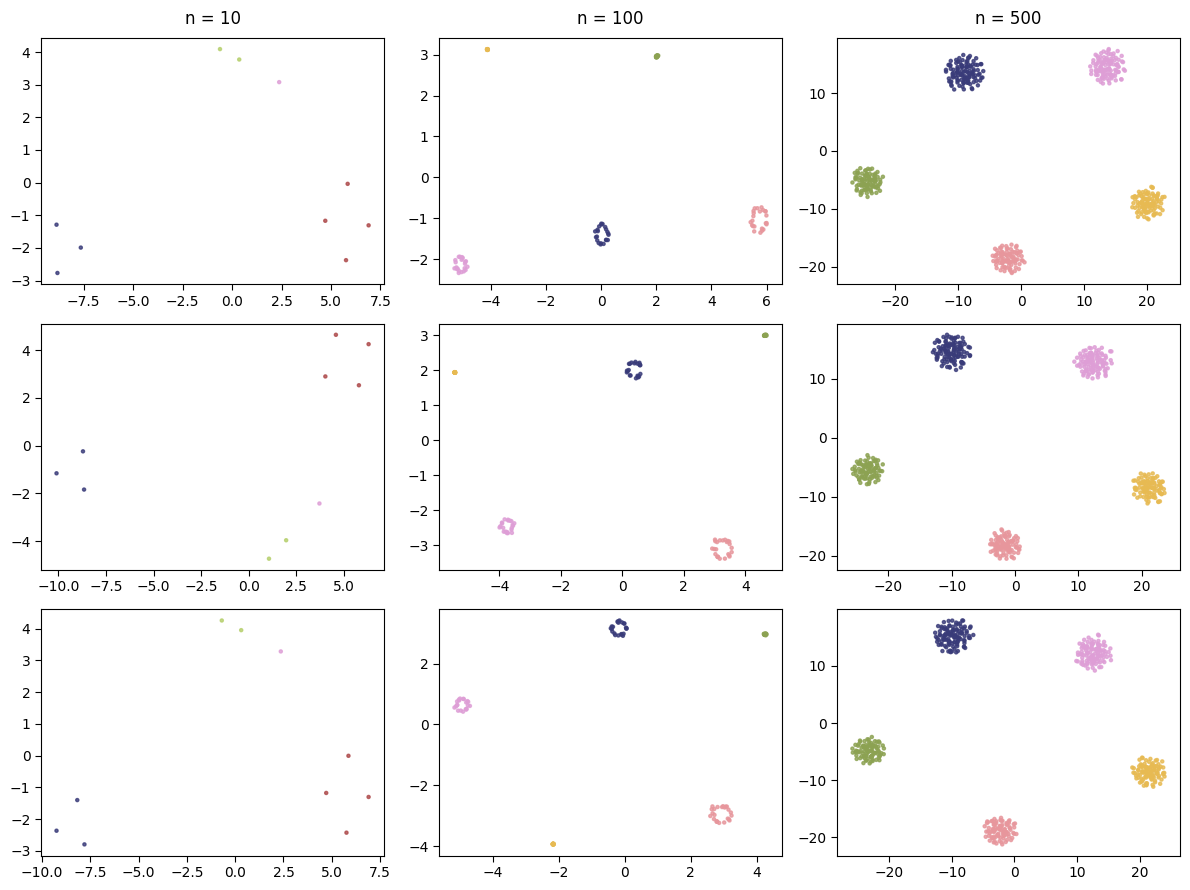

In [ ]:
plot_embedding_grid(embedding_dict, seeds, data_sizes, "Gaussian_Mixture", "standard")
plot_embedding_grid(embedding_dict, seeds, data_sizes, "Gaussian_Mixture", "rescaled", pointsize=7)

In [ ]:
data_sizes_4 = [100, 1000, 10000, 70000]
embedding_mnist = generate_embedding_dict_mnist(data_sizes_4, seeds)

Perplexity value 30 is too high. Using perplexity 3.00 instead
Perplexity value 33 is too high. Using perplexity 3.00 instead


n = 10, d = 50, b=0.15
Computed h_n = 0.7079
Using perplexity = 33.66 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 2.00
--------------------------------------------------------------------------------
TSNE(early_exaggeration=1.9952623149688797, exaggeration=1.9952623149688797,
     n_jobs=-1, perplexity=33.6605536290589, random_state=1, verbose=True)
--------------------------------------------------------------------------------
===> Finding 9 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=2.00, lr=5.01 for 250 iterations...
Iteration   50, KL divergence 0.5152, 50 iterations in 0.0301 sec
Iteration  100, KL divergence 0.5105, 50 iterations in 0.0291 sec
Iteration  150, KL divergence 0.5100, 50 iterations in 0.0260 sec
Iteration 

Perplexity value 30 is too high. Using perplexity 3.00 instead


Iteration  300, KL divergence 0.5096, 50 iterations in 0.0812 sec
Iteration  350, KL divergence 0.5098, 50 iterations in 0.0329 sec
Iteration  400, KL divergence 0.5092, 50 iterations in 0.0359 sec
Iteration  450, KL divergence 0.5104, 50 iterations in 0.0264 sec
Iteration  500, KL divergence 0.5101, 50 iterations in 0.0249 sec
   --> Time elapsed: 0.45 seconds


Perplexity value 33 is too high. Using perplexity 3.00 instead


n = 10, d = 50, b=0.15
Computed h_n = 0.7079
Using perplexity = 33.66 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 2.00
--------------------------------------------------------------------------------
TSNE(early_exaggeration=1.9952623149688797, exaggeration=1.9952623149688797,
     n_jobs=-1, perplexity=33.6605536290589, random_state=12, verbose=True)
--------------------------------------------------------------------------------
===> Finding 9 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=2.00, lr=5.01 for 250 iterations...
Iteration   50, KL divergence 0.5170, 50 iterations in 0.0414 sec
Iteration  100, KL divergence 0.5108, 50 iterations in 0.0354 sec
Iteration  150, KL divergence 0.5099, 50 iterations in 0.0180 sec
Iteration

Perplexity value 30 is too high. Using perplexity 3.00 instead


Iteration  450, KL divergence 0.5104, 50 iterations in 0.1256 sec
Iteration  500, KL divergence 0.5098, 50 iterations in 0.0374 sec
   --> Time elapsed: 0.41 seconds


Perplexity value 33 is too high. Using perplexity 3.00 instead


n = 10, d = 50, b=0.15
Computed h_n = 0.7079
Using perplexity = 33.66 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 2.00
--------------------------------------------------------------------------------
TSNE(early_exaggeration=1.9952623149688797, exaggeration=1.9952623149688797,
     n_jobs=-1, perplexity=33.6605536290589, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 9 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=2.00, lr=5.01 for 250 iterations...
Iteration   50, KL divergence 0.5163, 50 iterations in 0.0439 sec
Iteration  100, KL divergence 0.5106, 50 iterations in 0.0235 sec
Iteration  150, KL divergence 0.5101, 50 iterations in 0.0221 sec
Iteration

Perplexity value 30 is too high. Using perplexity 6.33 instead


Iteration  500, KL divergence 0.5103, 50 iterations in 0.0323 sec
   --> Time elapsed: 0.73 seconds


Perplexity value 34 is too high. Using perplexity 6.33 instead


n = 20, d = 50, b=0.15
Computed h_n = 0.6380
Using perplexity = 34.85 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 2.46
--------------------------------------------------------------------------------
TSNE(early_exaggeration=2.456456052231581, exaggeration=2.456456052231581,
     n_jobs=-1, perplexity=34.84759048924627, random_state=1, verbose=True)
--------------------------------------------------------------------------------
===> Finding 19 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.09 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=2.46, lr=8.14 for 250 iterations...
Iteration   50, KL divergence 0.7845, 50 iterations in 0.0537 sec
Iteration  100, KL divergence 0.7763, 50 iterations in 0.1192 sec
Iteration  150, KL divergence 0.7770, 50 iterations in 0.0360 sec
Iteration 

Perplexity value 30 is too high. Using perplexity 6.33 instead


Iteration  350, KL divergence 0.7766, 50 iterations in 0.0556 sec
Iteration  400, KL divergence 0.7764, 50 iterations in 0.0527 sec
Iteration  450, KL divergence 0.7764, 50 iterations in 0.0458 sec
Iteration  500, KL divergence 0.7765, 50 iterations in 0.0487 sec
   --> Time elapsed: 0.50 seconds


Perplexity value 34 is too high. Using perplexity 6.33 instead


n = 20, d = 50, b=0.15
Computed h_n = 0.6380
Using perplexity = 34.85 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 2.46
--------------------------------------------------------------------------------
TSNE(early_exaggeration=2.456456052231581, exaggeration=2.456456052231581,
     n_jobs=-1, perplexity=34.84759048924627, random_state=12, verbose=True)
--------------------------------------------------------------------------------
===> Finding 19 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.03 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=2.46, lr=8.14 for 250 iterations...
Iteration   50, KL divergence 0.7825, 50 iterations in 0.0367 sec
Iteration  100, KL divergence 0.7764, 50 iterations in 0.0337 sec
Iteration  150, KL divergence 0.7763, 50 iterations in 0.0721 sec
Iteration

Perplexity value 30 is too high. Using perplexity 6.33 instead


Iteration  400, KL divergence 0.7766, 50 iterations in 0.0930 sec
Iteration  450, KL divergence 0.7764, 50 iterations in 0.0521 sec
Iteration  500, KL divergence 0.7765, 50 iterations in 0.0557 sec
   --> Time elapsed: 0.62 seconds


Perplexity value 34 is too high. Using perplexity 6.33 instead


n = 20, d = 50, b=0.15
Computed h_n = 0.6380
Using perplexity = 34.85 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 2.46
--------------------------------------------------------------------------------
TSNE(early_exaggeration=2.456456052231581, exaggeration=2.456456052231581,
     n_jobs=-1, perplexity=34.84759048924627, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 19 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=2.46, lr=8.14 for 250 iterations...
Iteration   50, KL divergence 0.7840, 50 iterations in 0.0402 sec
Iteration  100, KL divergence 0.7765, 50 iterations in 0.0273 sec
Iteration  150, KL divergence 0.7764, 50 iterations in 0.0271 sec
Iteration

Perplexity value 30 is too high. Using perplexity 9.67 instead


Iteration  350, KL divergence 0.7767, 50 iterations in 0.0438 sec
Iteration  400, KL divergence 0.7765, 50 iterations in 0.0317 sec
Iteration  450, KL divergence 0.7764, 50 iterations in 0.0270 sec
Iteration  500, KL divergence 0.7766, 50 iterations in 0.0241 sec
   --> Time elapsed: 0.43 seconds


Perplexity value 35 is too high. Using perplexity 9.67 instead


n = 30, d = 50, b=0.15
Computed h_n = 0.6004
Using perplexity = 35.56 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 2.77
--------------------------------------------------------------------------------
TSNE(early_exaggeration=2.7741911146721807, exaggeration=2.7741911146721807,
     n_jobs=-1, perplexity=35.56127449677924, random_state=1, verbose=True)
--------------------------------------------------------------------------------
===> Finding 29 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=2.77, lr=10.81 for 250 iterations...
Iteration   50, KL divergence 0.9058, 50 iterations in 0.0405 sec
Iteration  100, KL divergence 0.9066, 50 iterations in 0.0328 sec
Iteration  150, KL divergence 0.9058, 50 iterations in 0.0342 sec
Iterati

Perplexity value 30 is too high. Using perplexity 9.67 instead


Iteration  500, KL divergence 0.9063, 50 iterations in 0.0890 sec
   --> Time elapsed: 0.47 seconds


Perplexity value 35 is too high. Using perplexity 9.67 instead


n = 30, d = 50, b=0.15
Computed h_n = 0.6004
Using perplexity = 35.56 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 2.77
--------------------------------------------------------------------------------
TSNE(early_exaggeration=2.7741911146721807, exaggeration=2.7741911146721807,
     n_jobs=-1, perplexity=35.56127449677924, random_state=12, verbose=True)
--------------------------------------------------------------------------------
===> Finding 29 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=2.77, lr=10.81 for 250 iterations...
Iteration   50, KL divergence 0.9046, 50 iterations in 0.0402 sec
Iteration  100, KL divergence 0.9067, 50 iterations in 0.1254 sec
Iteration  150, KL divergence 0.9057, 50 iterations in 0.0487 sec
Iterat

Perplexity value 30 is too high. Using perplexity 9.67 instead


Iteration  250, KL divergence 0.9059, 50 iterations in 0.0384 sec
Iteration  300, KL divergence 0.9061, 50 iterations in 0.0279 sec
Iteration  350, KL divergence 0.9064, 50 iterations in 0.0277 sec
Iteration  400, KL divergence 0.9061, 50 iterations in 0.0336 sec
Iteration  450, KL divergence 0.9060, 50 iterations in 0.0272 sec
Iteration  500, KL divergence 0.9062, 50 iterations in 0.0389 sec
   --> Time elapsed: 0.32 seconds


Perplexity value 35 is too high. Using perplexity 9.67 instead


n = 30, d = 50, b=0.15
Computed h_n = 0.6004
Using perplexity = 35.56 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 2.77
--------------------------------------------------------------------------------
TSNE(early_exaggeration=2.7741911146721807, exaggeration=2.7741911146721807,
     n_jobs=-1, perplexity=35.56127449677924, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 29 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=2.77, lr=10.81 for 250 iterations...
Iteration   50, KL divergence 0.9063, 50 iterations in 0.0599 sec
Iteration  100, KL divergence 0.9066, 50 iterations in 0.0513 sec
Iteration  150, KL divergence 0.9058, 50 iterations in 0.0451 sec
Iterat

Perplexity value 30 is too high. Using perplexity 13.00 instead


Iteration  500, KL divergence 0.9061, 50 iterations in 0.0534 sec
   --> Time elapsed: 0.69 seconds


Perplexity value 36 is too high. Using perplexity 13.00 instead


n = 40, d = 50, b=0.15
Computed h_n = 0.5750
Using perplexity = 36.08 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 3.02
--------------------------------------------------------------------------------
TSNE(early_exaggeration=3.024252145332219, exaggeration=3.024252145332219,
     n_jobs=-1, perplexity=36.07648811390505, random_state=1, verbose=True)
--------------------------------------------------------------------------------
===> Finding 39 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.06 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=3.02, lr=13.23 for 250 iterations...
Iteration   50, KL divergence 0.9592, 50 iterations in 0.0755 sec
Iteration  100, KL divergence 0.9528, 50 iterations in 0.0881 sec
Iteration  150, KL divergence 0.9527, 50 iterations in 0.0765 sec
Iteration

Perplexity value 30 is too high. Using perplexity 13.00 instead


Iteration  500, KL divergence 0.9527, 50 iterations in 0.0475 sec
   --> Time elapsed: 0.67 seconds


Perplexity value 36 is too high. Using perplexity 13.00 instead


n = 40, d = 50, b=0.15
Computed h_n = 0.5750
Using perplexity = 36.08 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 3.02
--------------------------------------------------------------------------------
TSNE(early_exaggeration=3.024252145332219, exaggeration=3.024252145332219,
     n_jobs=-1, perplexity=36.07648811390505, random_state=12, verbose=True)
--------------------------------------------------------------------------------
===> Finding 39 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=3.02, lr=13.23 for 250 iterations...
Iteration   50, KL divergence 0.9585, 50 iterations in 0.1100 sec
Iteration  100, KL divergence 0.9528, 50 iterations in 0.0712 sec
Iteration  150, KL divergence 0.9528, 50 iterations in 0.0743 sec
Iteratio

Perplexity value 30 is too high. Using perplexity 13.00 instead


Iteration  400, KL divergence 0.9528, 50 iterations in 0.0813 sec
Iteration  450, KL divergence 0.9528, 50 iterations in 0.0820 sec
Iteration  500, KL divergence 0.9527, 50 iterations in 0.0697 sec
   --> Time elapsed: 0.67 seconds


Perplexity value 36 is too high. Using perplexity 13.00 instead


n = 40, d = 50, b=0.15
Computed h_n = 0.5750
Using perplexity = 36.08 (base κ = 30, exponent α = 0.05)
Using early exaggeration = 3.02
--------------------------------------------------------------------------------
TSNE(early_exaggeration=3.024252145332219, exaggeration=3.024252145332219,
     n_jobs=-1, perplexity=36.07648811390505, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 39 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=3.02, lr=13.23 for 250 iterations...
Iteration   50, KL divergence 0.9584, 50 iterations in 0.0645 sec
Iteration  100, KL divergence 0.9529, 50 iterations in 0.0535 sec
Iteration  150, KL divergence 0.9528, 50 iterations in 0.0512 sec
Iteratio

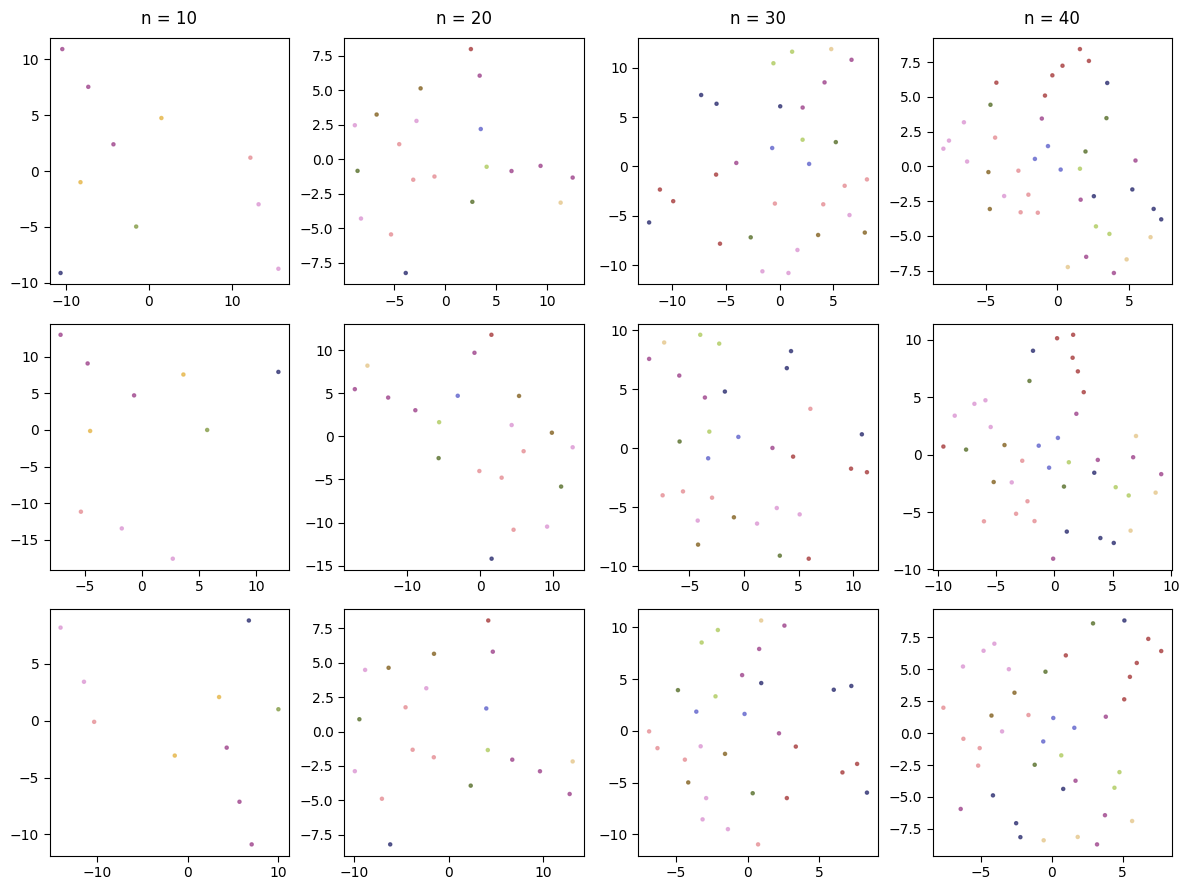

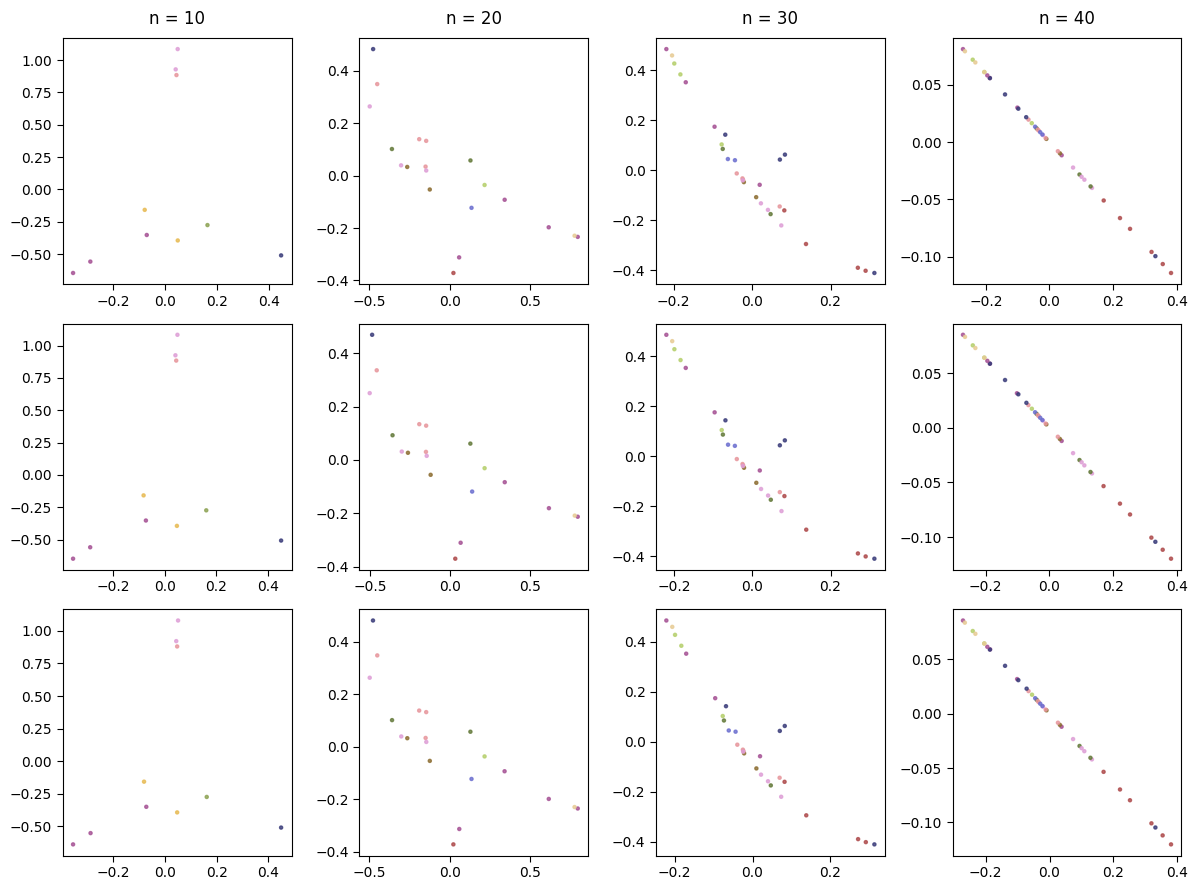

In [53]:
plot_embedding_grid(embedding_mnist, seeds, data_sizes_4, "MNIST", "standard")
plot_embedding_grid(embedding_mnist, seeds, data_sizes_4, "MNIST", "rescaled")